This notebook will be for data cleaning

Problem statement:
We are trying to optimize the WTWY signature-gathering team's placement for raising awareness of upcoming gala in June 2019. 

The end goals:
1. rank stations by foot traffic
2. plot 5 top stations by total traffic - hourly, daily, weekly
3. analyze demographics for top 5 stations - gender, income, industry
4. create scorecard with weighed combination of factors for each station

In [62]:
import pandas as pd

In [220]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [190504,190511,190518,190525]
mta_df = get_data(week_nums)

In [85]:
# fixing EXITS label
mta_df.rename(columns={"EXITS                                                               ":'EXITS'},inplace=True)

In [196]:
mta_df.shape

(822989, 12)

In [87]:
# converting to datetime
mta_df["DATE_TIME"] = pd.to_datetime(mta_df.DATE + " " + mta_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [88]:
# dropping duplicates
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [98]:
mta_daily = (mta_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        ['ENTRIES','EXITS'].first())

<ipython-input-98-277383eb6d8a>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mta_daily = (mta_df


In [193]:
mta_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,00:00:00,REGULAR,7035249,2384833,2019-04-27 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,04:00:00,REGULAR,7035269,2384840,2019-04-27 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,08:00:00,REGULAR,7035292,2384875,2019-04-27 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,12:00:00,REGULAR,7035392,2384951,2019-04-27 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,16:00:00,REGULAR,7035651,2385020,2019-04-27 16:00:00


In [192]:
# creating previous entries, previous exits, previous date
mta_daily[["PREV_DATE", "PREV_ENTRIES","PREV_EXITS"]] = (mta_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES",'EXITS']
                                                       .apply(lambda grp: grp.shift(1)))

<ipython-input-192-cbbfde3ea405>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mta_daily[["PREV_DATE", "PREV_ENTRIES","PREV_EXITS"]] = (mta_daily
<ipython-input-192-cbbfde3ea405>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mta_df[["PREV_DATE", "PREV_ENTRIES","PREV_EXITS"]] = (mta_df


ValueError: cannot reindex from a duplicate axis

In [122]:
mta_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
0,A002,R051,02-00-00,59 ST,04/27/2019,7035249,2384833,NaN,NaN,NaN
1,A002,R051,02-00-00,59 ST,04/28/2019,7036100,2385087,04/27/2019,7035249.0,2384833.0
2,A002,R051,02-00-00,59 ST,04/29/2019,7036746,2385256,04/28/2019,7036100.0,2385087.0
3,A002,R051,02-00-00,59 ST,04/30/2019,7038242,2385765,04/29/2019,7036746.0,2385256.0
4,A002,R051,02-00-00,59 ST,05/01/2019,7039729,2386229,04/30/2019,7038242.0,2385765.0


In [123]:
# dropping NAs in the new columns
mta_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [125]:
# calculating real daily entries and exits
def get_daily_entries(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

def get_daily_exits(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["EXITS"], row["PREV_EXITS"])
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

In [143]:
# dropping highest 1% of daily entries and activity
quant_filt = 0.99
q = data["DAILY_ENTRIES"].quantile(quant_filt)
data = data[data["DAILY_ENTRIES"] < q]
r = data["DAILY_ENTRIES"].quantile(quant_filt)
data = data[data["DAILY_ENTRIES"] < r]
s = data["DAILY_ACTIVITY"].quantile(quant_filt)
data = data[data["DAILY_ACTIVITY"] < s]
data = data.dropna() # apparently no issues with NaN cells; running as best practice
data.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS,DAILY_ACTIVITY
1,A002,R051,02-00-00,59 ST,04/28/2019,7036100,2385087,04/27/2019,7035249.0,2384833.0,851.0,254.0,1105.0
2,A002,R051,02-00-00,59 ST,04/29/2019,7036746,2385256,04/28/2019,7036100.0,2385087.0,646.0,169.0,815.0
3,A002,R051,02-00-00,59 ST,04/30/2019,7038242,2385765,04/29/2019,7036746.0,2385256.0,1496.0,509.0,2005.0
4,A002,R051,02-00-00,59 ST,05/01/2019,7039729,2386229,04/30/2019,7038242.0,2385765.0,1487.0,464.0,1951.0
5,A002,R051,02-00-00,59 ST,05/02/2019,7041303,2386712,05/01/2019,7039729.0,2386229.0,1574.0,483.0,2057.0


In [142]:
data = mta_daily

In [194]:
# applying functions to mta dataset
mta_daily["DAILY_ENTRIES"] = mta_daily.apply(get_daily_entries, axis=1, max_counter=500000)
mta_daily["DAILY_EXITS"] = mta_daily.apply(get_daily_exits, axis=1, max_counter=500000)

#mta['DAILY_ENTRIES'] = mta.apply(get_daily_entries, axis=1, max_counter=500000)
#mta["DAILY_EXITS"] = mta.apply(get_daily_exits, axis=1, max_counter=500000)


882 15418815.0
1435 4767402.0
335092671 3422305.0
412 3073070.0
161 4605408.0
681 6527713.0
65536 839317244.0
184608117 746094.0
238 2898346.0
50 1544092.0
607 3912014.0
196614 2998692.0
514 3755842.0
8 2020892.0
132263 737704.0
3003 6999467.0
408 8876564.0
1178879075 4471988.0
1221 649233.0
706 899109.0
4666 2201975.0
2665 666653.0
196633 68461839.0
200 36966261.0
1277 863113.0
1017 2357557.0
12 4887309.0
7 9441168.0
1058702 102390686.0
10 7602347.0
1463 1068632.0
183 724272.0
251 567679.0
29 6332751.0
30933207 6069289.0
115 12739117.0
1122 6546797.0
16779493 81157.0
637574909 2502854.0
68859156 436510383.0
607126914 594465.0
140397413 1577638340.0
458752 100663296.0
259 7480462.0
683737068 458752.0
905996437 3558247.0
7 13653544.0
182 10462950.0
2063649382 8123310.0
1129054878 2501599.0
1394 7550893.0
1778 2816656.0
335092104 2643003.0
68 906192.0
33 1931999.0
1516 8479992.0
2 167841841.0
16785950 71764.0
485 2358031.0
302 2844657.0
257 3657212.0
12 7146400.0
152 2893126.0
13 2881159

In [189]:
mta.DAILY_EXITS.describe()

AttributeError: 'DataFrame' object has no attribute 'DAILY_EXITS'

In [140]:
mta_daily.DAILY_ACTIVITY.describe()

count    130234.000000
mean       2051.670793
std        7231.710039
min           0.000000
25%         611.000000
50%        1548.000000
75%        2819.000000
max      849456.000000
Name: DAILY_ACTIVITY, dtype: float64

In [136]:
mta_daily.drop('DAILY EXITS',inplace=True, axis = 1)

In [138]:
# new column of daily activity
mta_daily['DAILY_ACTIVITY'] = mta_daily['DAILY_ENTRIES'] + mta_daily['DAILY_EXITS']

In [146]:
# here I begin to use the df 'data' instead of mta, because we applied statistical analysis that worked

In [147]:
data.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS,DAILY_ACTIVITY
1,A002,R051,02-00-00,59 ST,04/28/2019,7036100,2385087,04/27/2019,7035249.0,2384833.0,851.0,254.0,1105.0
2,A002,R051,02-00-00,59 ST,04/29/2019,7036746,2385256,04/28/2019,7036100.0,2385087.0,646.0,169.0,815.0
3,A002,R051,02-00-00,59 ST,04/30/2019,7038242,2385765,04/29/2019,7036746.0,2385256.0,1496.0,509.0,2005.0
4,A002,R051,02-00-00,59 ST,05/01/2019,7039729,2386229,04/30/2019,7038242.0,2385765.0,1487.0,464.0,1951.0
5,A002,R051,02-00-00,59 ST,05/02/2019,7041303,2386712,05/01/2019,7039729.0,2386229.0,1574.0,483.0,2057.0


In [179]:
# top 5 stations
top10_stations = (mta_daily.groupby(['STATION'])['DAILY_ACTIVITY'].sum()
                   .reset_index()
                   .sort_values(by='DAILY_ACTIVITY',ascending=False) 
                   .head(10)
                 )

top10_stations

,STATION,DAILY_ACTIVITY
61,34 ST-PENN STA,7734136.0
232,GRD CNTRL-42 ST,6699010.0
59,34 ST-HERALD SQ,5717204.0
46,23 ST,5334288.0
14,14 ST-UNION SQ,5332985.0
110,86 ST,4875680.0
352,TIMES SQ-42 ST,4791829.0
68,42 ST-PORT AUTH,4578932.0
225,FULTON ST,4168519.0
314,PATH NEW WTC,4078374.0


In [180]:
# plotting top 10 stations by daily activity
import matplotlib.pyplot as plt
%matplotlib inline

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

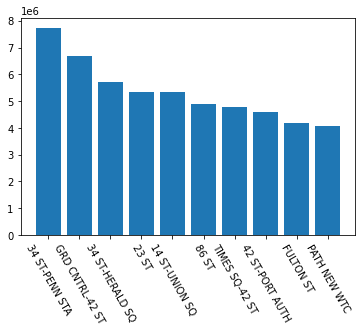

In [186]:
plt.bar('STATION','DAILY_ACTIVITY',data=top10_stations)
plt.xticks(rotation=300)

In [198]:
top10_stations

,STATION,DAILY_ACTIVITY
61,34 ST-PENN STA,7734136.0
232,GRD CNTRL-42 ST,6699010.0
59,34 ST-HERALD SQ,5717204.0
46,23 ST,5334288.0
14,14 ST-UNION SQ,5332985.0
110,86 ST,4875680.0
352,TIMES SQ-42 ST,4791829.0
68,42 ST-PORT AUTH,4578932.0
225,FULTON ST,4168519.0
314,PATH NEW WTC,4078374.0


In [206]:
mta_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,00:00:00,REGULAR,7035249,2384833,2019-04-27 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,04:00:00,REGULAR,7035269,2384840,2019-04-27 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,08:00:00,REGULAR,7035292,2384875,2019-04-27 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,12:00:00,REGULAR,7035392,2384951,2019-04-27 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,16:00:00,REGULAR,7035651,2385020,2019-04-27 16:00:00


My next goal is to plot the hourly variation of traffic in the top three stations - Penn station, Grand Central, and Herald Square.

In [215]:
mta_df = mta_df[~mta_df.index.duplicated()]

In [221]:
mta_df[mta_df.index.duplicated()]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/04/2019,00:00:00,REGULAR,7044468,2387700
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/04/2019,04:00:00,REGULAR,7044495,2387706
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/04/2019,08:00:00,REGULAR,7044509,2387740
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/04/2019,12:00:00,REGULAR,7044568,2387757
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/04/2019,16:00:00,REGULAR,7044743,2387774
...,...,...,...,...,...,...,...,...,...,...,...
203358,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/24/2019,05:00:00,REGULAR,5554,378
203359,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/24/2019,09:00:00,REGULAR,5554,378
203360,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/24/2019,13:00:00,REGULAR,5554,378
203361,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/24/2019,17:00:00,REGULAR,5554,378


In [229]:
mta_df.iloc[0]

C/A                                                                           A002
UNIT                                                                          R051
SCP                                                                       02-00-00
STATION                                                                      59 ST
LINENAME                                                                   NQR456W
DIVISION                                                                       BMT
DATE                                                                    04/27/2019
TIME                                                                      00:00:00
DESC                                                                       REGULAR
ENTRIES                                                                    7035249
EXITS                                                                      2384833
Name: 0, dtype: object

In [214]:
mta_df[["PREV_DATE", "PREV_ENTRIES","PREV_EXITS"]] = (mta_df
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES",'EXITS']
                                                       .apply(lambda grp: grp.shift(1)))

<ipython-input-214-f4675b6a5f3c>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mta_df[["PREV_DATE", "PREV_ENTRIES","PREV_EXITS"]] = (mta_df


ValueError: cannot reindex from a duplicate axis

In [202]:
# creating objects for each station to plot
mask = (mta['STATION'] == '34 ST-PENN STA')
penn = mta[mask]

mask = (mta['STATION'] == 'GRD CNTRL-42 ST')
cntr = mta[mask]

mask = (mta['STATION'] == '34 ST-HERALD SQ')
herald = mta[mask]

In [203]:
penn.head()

,STATION,DATE,TIME,ENTRIES,EXITS
52522,34 ST-PENN STA,05/05/2019,00:00:00,21779,68642
52523,34 ST-PENN STA,05/05/2019,04:00:00,21784,68653
52524,34 ST-PENN STA,05/05/2019,08:00:00,21793,68728
52525,34 ST-PENN STA,05/05/2019,12:00:00,21867,68901
52526,34 ST-PENN STA,05/05/2019,16:00:00,21991,69132
